## This is a script to solve for the motion of a massive rod double pendulum using DCA

#### Imports

In [1]:
# Numerics and plotting 
import numpy as np
import scipy as sc
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# DCA stuff 
import MBstructs as MB
import MultiBodyFuncts as MBF
import DCA

# global plotting and printing config
%matplotlib inline
np.set_printoptions(precision=4,suppress=True)

#### Helper Functions

In [2]:
def get_system_topology(state):
 
    l = 1.0
    
    ntsteps,nbodies = np.shape(state)
    q = state[:,:nbodies/2]
    theta = np.cumsum(q,1)
    C = [[np.array([[ np.cos(angle), np.sin(angle)],\
                    [-np.sin(angle), np.cos(angle)],[0,0,1]]) 
      for angle in tstep] for tstep in theta]
    R = [[np.dot(CBN,np.array([0,l])) for CBN in timestep] \
                                      for timestep in C]
    R = [np.cumsum(r,0) for r in R]
    
    x = [np.hstack((np.array([0]),r[:,0])) for r in R]
    y = [np.hstack((np.array([0]),r[:,1])) for r in R]
    return x,y

def sys_update(x, y, line):
    line.set_data(x, y)
    return line,

In [3]:
# This function prepares the system for the DCA algorithm 
def initialize(b,x,n):
    val1=0
    val2=np.zeros((3))
    val3=np.zeros((3))
    for k in range(0,n):
        val1=val1+x[k]
#         print(val1)
        b[k].C0=MBF.simdcm(val1,np.array((0,0,1)))
        val2=val2+np.array((0,0,x[k+n]))
        b[k].w=val2
#         print(b[k].w)
#         print(b[k].C0)
        b[k].w1=np.array((0,0,x[k+n]))
        b[k].rs(b[k].l/2.0,np.array((0,-1,0)))
        b[k].Vcm=val3+np.cross(b[k].w,b[k].r10)
        val3=val3+np.cross(b[k].w,b[k].r12)
        b[k].Inertia2()#transformed inertia matrix
        b[k].Mmatrix()#Mass matrix and its inverse
        b[k].Forces(np.array((0,-1,0)))
        b[k].shifters()#S matrices
        b[k].zs()#zeta values

In [4]:
def simulate(state,t,n,i,bbs,jjs,BC1,BC2):
#     This function extracts the generalized coordinates from the solution of the equations of motion 
#     after calling the DCA to solve the equations of motion 

    #Initialize the system
    initialize(bbs,state,n)
    
    #Call the Recursive DCA Algorithm
    #This returns a list of the form:
    #[A11,A12,A21,A22,...,An1,An2]
    #where Axy corresponds to the acceleration
    #of the yth handle of the xth body
    ll=DCA.openR(n,0,bbs,jjs,BC1,BC2)

    #loop to fill d_dt with the acceleration values
    d_dt=np.zeros((2*n))
    for j in range(0,n):
        if j == 0:
            A1=ll.pop(0)
            d_dt[j+n]=np.dot(np.transpose(jjs[j].P),A1)
        else:
            A2= ll.pop(0)
            A1=ll.pop(0)
            d_dt[j+n]=np.dot(np.transpose(jjs[j].P),(A1-A2))
    
    #add the velocities to d_dt and return to the integrator
    d_dt[:n]=state[n:]
    return d_dt 

#### System specifications and Initial Conditions

In [5]:
# Specify number of bodies
n = 3

# q1 and q2 are measured as the angle the rod makes with -n2 axis
q_init=np.pi/6*np.zeros((n))
q_init[0]=np.pi/2

qdot_init=0.1*np.zeros((n))

ic=np.zeros((2*n))
ic[:n]=q_init
ic[n:]=qdot_init

#Length of time of the simulation
Time=np.arange(0,.005,.001)

#### System Initialization

In [6]:
# # Create a list of Bodies and Joints
# bs=[]
# js=[]

# for i in range(0,n):
#     bs.append(MB.Body())
#     js.append(MB.Joint())

# # Joint Properties
# for joint in js:
#     joint.PDmatrix(np.array((0,0,1,0,0,0)),1)

# # Body Properties
# for i in range (0,n):
#     bs[i].m=1.0
#     bs[i].l=1.0
#     bs[i].Inertia(bs[i].m*(bs[i].l**2)/12,1,bs[i].m*(bs[i].l**2)/12)
# Create a list of Bodies and Joints
bs=[]
js=[]

for i in range(0,n):
    bs.append(MB.Body())
    js.append(MB.Joint(np.array([0,0,1,0,0,0]),1))

# Body Properties
for i in range (0,n):
    bs[i].m=1.0
    bs[i].l=1.0
    bs[i].Inertia(bs[i].m*(bs[i].l**2)/12,1,bs[i].m*(bs[i].l**2)/12)

In [17]:
initialize(bs,ic,n)

#### Simulate it

In [8]:
# odeint is the numerical integrator used
yy=odeint(simulate,ic,Time,(n,0,bs,js,2,1))

#### Check Results and Plot

In [9]:
# x,y = get_system_topology(yy)

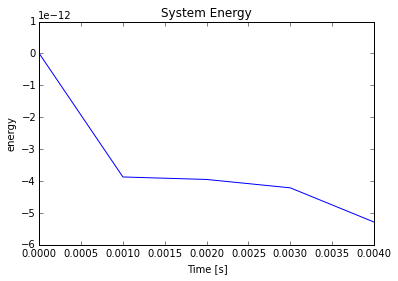

<function matplotlib.pyplot.show>

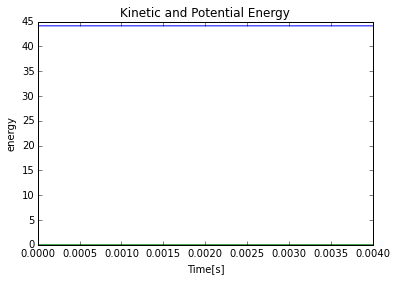

In [10]:
# The energy of the system is calculated and plotted
energy=MBF.PendEnergy(yy,bs)
KE=energy[:,0]
PE=energy[:,1]
TE=energy[:,2]

plt.plot(Time,TE-TE[0])
plt.xlabel("Time [s]")
plt.ylabel("energy")
plt.title("System Energy")
plt.show()

plt.plot(Time,PE,Time,KE)
plt.xlabel("Time[s]")
plt.ylabel("energy")
plt.title("Kinetic and Potential Energy")
plt.show

In [11]:
# Pot Generalized Coordinates
# plt.plot(Time,yy[:,:n])
# plt.xlabel("Time [s]")
# plt.ylabel("Generalized Coordinates [Rad]")
# plt.title("System Response")

# plt.show()

# plt.plot(Time,yy[:,n:])
# plt.xlabel(("Time[s]"))
# plt.ylabel(("Generalized Speeds [Rad/s]"))
# plt.title("System Response")

# plt.show()

In [18]:
bs[0].r01

array([-0.5,  0. , -0. ])

In [21]:
np.dot(bs[0].r01,bs[0].C0)

array([-0. , -0.5,  0. ])

In [20]:
bs[0].C0

array([[ 0.,  1.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [14]:
[print(y) for y in yy]

[ 1.5708  0.      0.      0.      0.      0.    ]
[ 1.5708  0.     -0.     -0.0125  0.0158 -0.0045]
[ 1.5708  0.     -0.     -0.0249  0.0317 -0.0091]
[ 1.5707  0.0001 -0.     -0.0374  0.0475 -0.0136]
[ 1.5707  0.0001 -0.     -0.0498  0.0634 -0.0181]


[None, None, None, None, None]